In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fileDownloaded = drive.CreateFile({'id':'https://drive.google.com/file/d/1uTHL59_tid1Tu4O9_T2zHZYIYu0D6bit/view?usp=sharing'})
file_list = drive.ListFile({'q': "'1ATVDsYj_YhpzSmYhV5X-q21CYzujQ2As' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))
data_downloaded_user_likes = drive.CreateFile({'id': '1uTHL59_tid1Tu4O9_T2zHZYIYu0D6bit'})
data_downloaded_user_likes.GetContentFile('users-likes.csv')
data_downloaded_users = drive.CreateFile({'id': '1XRppHA9JDYGw1gio1Y5XpzxT9uwmJiU1'})
data_downloaded_users.GetContentFile('users.csv')
data_downloaded_likes = drive.CreateFile({'id': '1cHKEtaDRtQBFC6MCDcFMP_Wu8AgrwK4D'})
data_downloaded_likes.GetContentFile('likes.csv')

users=pd.read_csv('users.csv')
likes=pd.read_csv('likes.csv')
ul=pd.read_csv('users-likes.csv',error_bad_lines=False,engine='python')

title: likes.csv, id: 1cHKEtaDRtQBFC6MCDcFMP_Wu8AgrwK4D
title: users.csv, id: 1XRppHA9JDYGw1gio1Y5XpzxT9uwmJiU1
title: users-likes.csv, id: 1uTHL59_tid1Tu4O9_T2zHZYIYu0D6bit


In [4]:
#users=pd.read_csv('./sample_dataset/users.csv')
#likes=pd.read_csv('./sample_dataset/likes.csv')
#ul=pd.read_csv('./sample_dataset/users-likes.csv')
users.head()

,userid,gender,age,political,ope,con,ext,agr,neu
0,54f34605aebd63f7680e37ffd299af79,0,33,0.0,1.26,1.65,1.17,-1.76,0.61
1,86399f8c44ba54224b2e60177ca89fa9,1,35,0.0,1.07,0.17,-0.14,1.49,0.30
2,84fab50f3c60d1fdc83aa91b5e584a78,1,36,0.0,0.89,1.28,0.86,1.07,0.99
3,f3b8fdaccce12ef6352bfad4d6052fe9,0,39,NaN,0.33,-1.01,-0.33,-0.68,0.92
4,8b06ea5e9cb87c61da387995450607f7,0,31,NaN,0.15,0.47,1.17,-1.01,-0.32


In [5]:
ul.head()

,userid,likeid
0,71bc7c0901488aec6d30f0add257e7c5,3c1636c878e6eb2acfd00c6b61086e38
1,978ab8e90c4d6ad1a48ef5c973b62f4d,feca46ddb8ef04f86172ace0cb7e004c
2,85123b0e358907725cf19a2cb0ec3983,b65f46d64c688fe98bdbcf93a76a71fc
3,ce110562b3e2f7e5cad3775b32d9caa5,b65f46d64c688fe98bdbcf93a76a71fc
4,8188d20745471273fa69ba44a5b28473,b65f46d64c688fe98bdbcf93a76a71fc


In [6]:
likes.head()

,likeid,name
0,3c1636c878e6eb2acfd00c6b61086e38,REIGN by Paul Gibson
1,feca46ddb8ef04f86172ace0cb7e004c,Cupcake Wishes & Birthday Dreams
2,b65f46d64c688fe98bdbcf93a76a71fc,Yo también me rei de la caída de otro jejeje
3,9c5c8bb82d2cd46fbd7582f944fe370e,Abraham Joshua Heschel Day School- Alumni Network
4,2d82fa84ad79b085dc516dde154327a2,Kennesaw Farmer's Market


In [7]:
df=ul.iloc[:50957]

In [8]:
sparse_matrix=df.groupby(['userid', 'likeid']).size().unstack(fill_value=0)

In [9]:
sparse_matrix.head()

likeid,0002d0025b6a8d31e15a4365340fd45b,00039ce02d551a4ea92a10faf108d452,00138152bb541898e326a1c1dd2866fb,003b533fd57a8946d3b40c012120d42f,003dc078204728c637fd8d53e19dafcf,003f0eec527f1b20be276fe37f7b2c50,003f7066a66887c8f65d59622152768f,004d06029f87dcda783ae6dff1a0cf07,005ca3f1a1838770fbe2e9351926e43e,0064d3c358a3c67b6d0393e139029593,0067c6e8e150b4ef700ca9c2ce8845b7,0087f817fdffd5dba7afe8e9280267ba,0089bd6b6daaeb8057b0498681fd1d77,0093e0f73a24f888bb3e51bd0c8d2833,0093ebe24c02dc4f590ba4a5ac999ee4,009da8e9836321280c2a1f6839d1cfeb,00c9fa765cd80d1d43573cf008e124cd,00d8091db91644e4980c69768850cdc2,00d9d99cbde19fd33819da40918cf837,00f36f66fdaa758d88a8f11fc7f75d8f,00f7039e79447293f2533b698b646091,00ff28e1f51c749014175e452ad67ed8,011078021c4047aadd531d0b816c6b6f,0115e83069935d9e7ba45b37f604094a,011beabefcd212c4611eb245c668d26b,012af64734ec37c19fc609020714d547,015656939623fd9520ba99c1cbb8d0f4,016da46f2d26397c42adeaa43f207e78,017c6650e8e74ff1506a05d0729ba666,019567ed4bc3db3cd16c88d917917ea5,0198fce8b6dd8d2d229640e053b3e4a0,01a0ca751ce1cfe73e80dc857400fecc,01bf556f9d395cbbb69d48bc7c13b9a4,01ca63a0617f23386614d6bd6c0c1efe,01caf2825650d94e13b47d7c3e457bf1,01e00f5416e17ff3ed111e329fb1df80,01f6cc36e6e9ea6a8ac7af37c4e1aa73,01f6d264efb0a560af301f6ec4edb675,02139f2bf37e6c9935a3ea2d80961759,021930683fc02aa16350addb65a5bc77,...,feabebcd67219d113e6b49486c3032a2,feacc65115a31cb38c6432e5ed03048f,feb13de71c971ce888292b57ba968f73,feb2e994eb99fd865c43d925c8a6a14e,feb39e77512572e4d796df60bc61bd5c,feca46ddb8ef04f86172ace0cb7e004c,fedfb4aac392726014b5f1681a4f20c1,feed659d562ab9bccdbb41c7172a331a,fef262471de6340cedacdcdabc5ecff2,fef40308771ae2db7633330bfe3dee3f,fef429daeda1339c48c35fbf957e81b7,fefa4d2607ffe81d3dfcc9afe93c7a21,fefc691dac6df2502fb226e3c0232323,ff101fa9673b2be39e2b5101f09d819f,ff14f1dc829e88cbd758eef91c94f8f2,ff1e80543e03c31246291d854f622ac8,ff216f0a601614f0dd733f74d61fa2ad,ff2626a109cb0d1a0e8fcee20f616aba,ff27b49cdab060b6b7769f028982ae66,ff2dfbb06d65890834029c77cd2f89f8,ff325851dacf50aad777fedbfb09fd5b,ff61b33266b9d857213ff6def41de2fb,ff6abc9306e6d02dc622baf6c7438d45,ff717d02924c4daad216c5ff74545a47,ff728a1cb3e7f453500a08b5180e9756,ff7cfc3c78b23a73e9b2282fe03dc309,ff942e33b5dd87938afd0aa3ac56b970,ffa821bdbd89269c49bbf1cd28dc63e3,ffb673e438adff4f8fcffab2b64e153c,ffb75afc61fed9cd3a208d124051381f,ffb85b29fc5dce3eff171bc76d8eeae4,ffba7e4d11cef63b4c9117e0774046bc,ffc4c436cffabbe34e4421caa5b18c33,ffcf3348c3d649e5a0a31b25022306c0,ffd8a8967c3069aecad8767d205b7dc9,ffe07037dfba0759db00f1de67abab5d,ffe1a6e3052b79858e3cf1669e625dc9,ffe882beafe058855a262a3b0978937e,fff77b8c9d2b67bfbaaf56d7459b3274,fffbbe882bb89bce2d458ec528006763
userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0002abedba29d5a7fc1d34834b8846d7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00035a29fa913610d9dfd1c6d6a15fd6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
000769fb960a5900187f6631c4bb7264,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0007ef89a1a6d9440c3863bad4202f21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00082a96ca78b2883a3e24b9e8823567,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
user_ids=sparse_matrix.index.values.tolist()

In [11]:
sparse_matrix_n=np.array(sparse_matrix)

In [12]:
#Trimming 
sparse_matrix_n1=sparse_matrix_n[:,np.sum(sparse_matrix_n, axis=0)>1]
print(sparse_matrix_n1.shape)
sparse_matrix_n2=sparse_matrix_n1[np.sum(sparse_matrix_n, axis=1)>1]
print(sparse_matrix_n2.shape)

(25257, 2342)
(9992, 2342)


In [13]:
#print(user_ids.shape)
user_ids=np.array(user_ids)
user_ids=user_ids[np.sum(sparse_matrix_n, axis=1)>1]

In [14]:
sparse_matrix_n2

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [15]:
random.seed(68)

In [16]:
n_components=5
svd = TruncatedSVD(n_components=5)
X_reduced = svd.fit_transform(sparse_matrix_n2)
df_svd = pd.DataFrame(data=X_reduced, index=[i for i in range(len(user_ids))], columns=['svd_'+str(i+1) for i in range(n_components)])
df_svd['userid']=user_ids
df_svd.head()

,svd_1,svd_2,svd_3,svd_4,svd_5,userid
0,1.576169,0.202196,0.460868,-0.335003,-0.079080,00035a29fa913610d9dfd1c6d6a15fd6
1,0.834194,-0.528804,-0.372666,0.003381,-0.114872,00082a96ca78b2883a3e24b9e8823567
2,0.056317,-0.017725,0.082691,0.780414,-0.204151,00217ff065b47f79902cb8b57b897608
3,0.005412,0.004482,0.005724,0.006332,0.010378,0026109987824beae6d0251ff52f093e
4,0.004538,0.000962,-0.004915,0.007960,-0.006291,002cff3e5a5e1e3a4874d3768dd5e6be


In [17]:
left = users.set_index('userid')
right = df_svd.set_index('userid')
combined_table=left.join(right, how='inner')
combined_table.head()

,gender,age,political,ope,con,ext,agr,neu,svd_1,svd_2,svd_3,svd_4,svd_5
userid,,,,,,,,,,,,,
c6a9a43058c8cc8398ca6e97324c0fae,0,47,NaN,-0.31,-0.57,-0.89,0.41,1.17,0.000000,-0.000000,0.000000,-0.000000,-0.000000
172e5d8611cb33a8b466a29705bb1bda,0,28,NaN,0.79,1.06,-0.89,-1.01,-0.01,0.003406,0.002156,0.003560,0.010386,-0.006414
f9ed42fd1c0e0e1ecd2ba3fdb54ce6fa,1,29,0.0,-0.31,-0.94,-0.77,-1.76,1.05,0.084353,-0.009847,-0.008794,0.113817,-0.169537
eca69bfad8f4f2b193b2592248101b7f,1,28,0.0,-0.68,0.54,-0.52,-1.01,-0.51,0.835180,-0.528841,-0.369458,0.013254,-0.116562
c045fd40e4e1dfdd0dfcd9c30f690f84,1,30,0.0,1.53,1.65,-0.14,1.41,-0.38,0.004506,0.002588,-0.004422,0.008588,-0.007601


In [18]:
combined_table.corr()

,gender,age,political,ope,con,ext,agr,neu,svd_1,svd_2,svd_3,svd_4,svd_5
gender,1.000000,0.006989,-0.026141,-0.021108,-0.000021,-0.013182,0.033783,0.225765,-0.062500,-0.095983,0.089164,0.178241,0.034980
age,0.006989,1.000000,-0.025313,0.073102,0.164837,0.043922,0.091851,-0.074951,-0.163858,0.048733,-0.090183,-0.001163,-0.158644
political,-0.026141,-0.025313,1.000000,-0.419679,0.142928,0.026795,0.036373,-0.088177,0.048995,-0.034834,0.037325,-0.018295,0.056226
ope,-0.021108,0.073102,-0.419679,1.000000,0.089158,0.236131,0.120279,-0.115254,-0.047349,0.027041,-0.031276,-0.025144,-0.081085
con,-0.000021,0.164837,0.142928,0.089158,1.000000,0.259246,0.258072,-0.394704,-0.026646,-0.010614,-0.037400,0.025299,-0.072351
ext,-0.013182,0.043922,0.026795,0.236131,0.259246,1.000000,0.250768,-0.444976,0.061324,0.031871,-0.041914,-0.010348,-0.006450
agr,0.033783,0.091851,0.036373,0.120279,0.258072,0.250768,1.000000,-0.435083,0.004109,-0.037772,-0.041975,0.001294,-0.049853
neu,0.225765,-0.074951,-0.088177,-0.115254,-0.394704,-0.444976,-0.435083,1.000000,-0.029401,-0.012849,0.058966,0.098115,0.049106
svd_1,-0.062500,-0.163858,0.048995,-0.047349,-0.026646,0.061324,0.004109,-0.029401,1.000000,-0.058391,-0.090121,-0.289917,-0.043586
svd_2,-0.095983,0.048733,-0.034834,0.027041,-0.010614,0.031871,-0.037772,-0.012849,-0.058391,1.000000,-0.006565,-0.021120,-0.003175


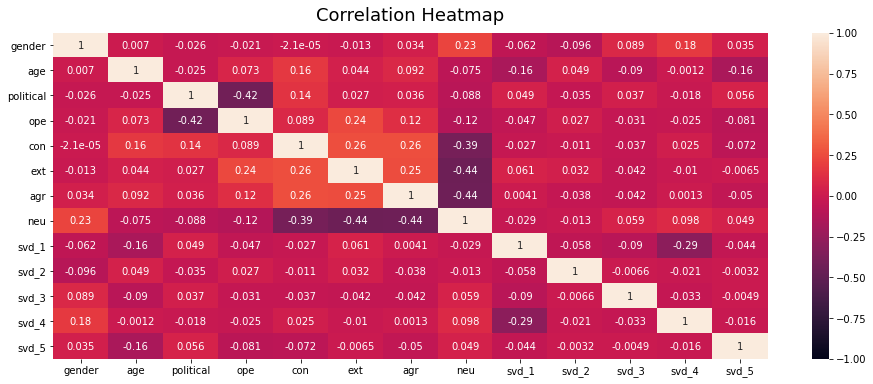

In [19]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(combined_table.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

In [20]:
#X_reduced[0]
print(svd.explained_variance_ratio_)
print(svd.explained_variance_ratio_.sum())
print(svd.singular_values_)

[0.06633252 0.05456201 0.03567127 0.02201882 0.02138327]
0.19996789606195053
[60.20281345 40.76576925 33.05804358 27.16310336 25.4964577 ]


In [42]:
n_components_svd=50
response_columns=8
result=np.zeros((n_components_svd,response_columns))
titles = ['Gender','Age','Political','ope','con','ext','agr','neu']
for n_c in range(1,n_components_svd+1):
    #print('model learning in progres for components',n_c)
    svd = TruncatedSVD(n_components=n_c)
    X_reduced = svd.fit_transform(sparse_matrix_n2)
    df_svd = pd.DataFrame(data=X_reduced, index=[i for i in range(len(user_ids))], columns=['svd_'+str(i+1) for i in range(n_c)])
    df_svd['userid']=user_ids
    left = users.set_index('userid')
    right = df_svd.set_index('userid')
    combined_table=left.join(right, how='inner')
    #for all y response variable except political one
    c_t=np.array(combined_table)
    X,y=c_t[:,response_columns:],c_t[:,:response_columns]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    #for political response variable
    c_t1=np.array(combined_table.dropna())
    X1,y1=c_t1[:,response_columns:],c_t1[:,2]
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.33, random_state=42)
    for y_col in range(response_columns):
        #for categorical columns
        if y_col in [0,2]:
            if y_col==2:
                clf = LogisticRegression().fit(X_train1, y_train1)
                auc=roc_auc_score(y_test1, clf.predict_proba(X_test1)[:, 1])
                result[n_c-1,y_col]=auc
                if(n_c==50):
                    print('no of component',n_c,'Political response variable auc',auc)
            else:
                clf = LogisticRegression().fit(X_train, y_train[:,y_col])
                auc=roc_auc_score(y_test[:,y_col], clf.predict_proba(X_test)[:, 1])
                result[n_c-1,y_col]=auc
                if(n_c==50):
                    print('no of component',n_c,'Gender response variable auc',auc)
            
        else:
            reg = LinearRegression().fit(X_train, y_train[:,y_col])
            y_pred=reg.predict(X_test)
            r=np.corrcoef(y_test[:,y_col],y_pred)[0][1]
            result[n_c-1,y_col]=r
            if(n_c==50):
                print('Number of component:',n_c,' y_col:',titles[y_col],'Accuracy(correlation)',r)
    

no of component 50 Gender response variable auc 0.7130780795947227
Number of component: 50  y_col: Age Accuracy(correlation) 0.3841129040422152
no of component 50 Political response variable auc 0.585892264305858
Number of component: 50  y_col: ope Accuracy(correlation) 0.14891999258020333
Number of component: 50  y_col: con Accuracy(correlation) 0.1383674364366912
Number of component: 50  y_col: ext Accuracy(correlation) 0.08209152468220343
Number of component: 50  y_col: agr Accuracy(correlation) 0.09505173136741513
Number of component: 50  y_col: neu Accuracy(correlation) 0.13329111452542114


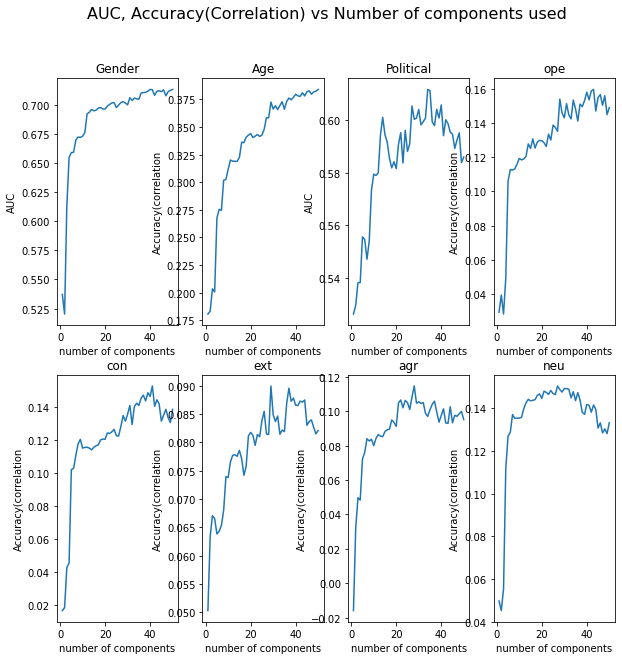

<Figure size 432x288 with 0 Axes>

In [43]:
titles = ['Gender','Age','Political','ope','con','ext','agr','neu'] #title
fig, axs = plt.subplots(2,4,figsize=(10, 10))
fig.suptitle('AUC, Accuracy(Correlation) vs Number of components used', fontsize=16)
for kk, (ax,yy) in enumerate(zip(axs.reshape(-1),zip(*result))):
    #print(yy)
    ax.plot([i+1 for i in range(50)],yy)
    ax.set_title(titles[kk])
    ax.set_xlabel('number of components')
    if kk in [0,2]:
      ax.set_ylabel('AUC')
    else:
      ax.set_ylabel('Accuracy(correlation')
#fig.delaxes(axs[1][1])
plt.show()
plt.savefig('result.png', dpi=300, bbox_inches='tight')